The following cell loads required modules

In [1]:
# import required models for plotting and for numerical operations
import numpy as np
import matplotlib.pyplot as plt
import math

Assignment:  Define any required constants at the top of this cell.  Also complete the definitions of the functions for saturation vapor pressure, saturation mixing ratio, and saturation specific humidity.

In [2]:
#define physical constants and standard functions

Rd = 287.05
g = 9.80665
hPa = 100.0
epsilon = 0.622


def esat(TK):
    '''Given temperature in Kelvin, use Bolton formula to compute
    vapor pressure in Pa.'''
    TC = TK-273.15
    return(611.2*np.exp(17.67*TC/(TC+243.5)))   # Bolton formula
    
def wsat(TC,p):
    '''Given temperature in Celsius and pressure in Pa, compute
    non-dimensional saturation mixing ratio.'''
    TK = TC + 273.15
    es = esat(TK)
    w = (epsilon * es) / (p - es)
    return(w)

def qsat(TC,p):
    '''Given temperature in Celsius and pressure in Pa, compute
    non-dimensional specific humidity.'''
    q = wsat(TC, p) / (1 + wsat(TC, p))
    return(q)

def dewpoint(w):
    es = esat(TC + 273.15)
    A = 2.53e11
    B = -5420
    dew = B / math.log(es / A)
    return(dew)

In [3]:
print qsat(30, 101000)

0.026568170862854675


In [4]:
# Test that above functions produce correct values

TK = 273.15
TC = 0.
es = esat(TK)
print es

p = 900*hPa
ws = wsat(TC,p)
print ws

# Correct values should be 611.2 and 0.00425...

611.2
0.004252953390133887


In [5]:
hPa = 100.0

Define  a class that stores a sounding with appropriate methods and attributes.

ASSIGNMENT:  Add code to extract not only the temp, dewpoint, and pressure but also the geopotential height Zsnd.  Also add code to compute and save the water vapor mixing ratio w.  Finally, add methods to (a) compute geopotential height Zcmp and (b) plot both Zsnd and Zcomp vs. pressure (same vertical scale as for basic profile plot.)

In [6]:
class Sounding():
    def __init__(self, filename):

        filename = '20130927_143732_EDT.tsv'
        self.time = []
        self.Pscl = []
        self.T = []
        self.RH = []
        self.v = []
        self.u = []
        self.Height = []
        self.P = []
        self.TD = []
        self.TDc = []
        self.TC = []
        self.MR = []
        self.DD = []
        self.FF = []
        self.AZ = []
        self.Range = []
        self.Lon = []
        self.Lat = []
        self.SpuKey = []
        self.UsrKey = []
        self.RadarH = []
        self.stid = 'Rooftop'
        self.dtime = filename.split('_')[0]

        with open(filename, 'r') as f:
            for line in f.readlines()[39:]:
                split_lines = line.split()
                for variable, assign_to in zip(split_lines,[self.time, self.Pscl, self.T, self.RH, self.v, self.u, self.Height, self.P, self.TD, self.MR, self.DD, self.FF, self.AZ, self.Range, self.Lon, self.Lat, self.SpuKey, self.UsrKey, self.RadarH]):
                    assign_to.append(float(variable))

        self.nlevels = len(self.T)
        self.p = []
        for item in self.P:
            new = item
            self.p.append(new)
        self.wsat = []
        for temp, pres in zip(self.T, self.p):
            TCel = temp - 273.15
            self.TC.append(TCel)
            new = wsat(TCel, pres)
            self.wsat.append(new)
            
        for temp in self.TD:
            TDcel = temp - 273.15
            self.TDc.append(TDcel)
        
        self.compute_Z()  # Independently compute Z from hypsometric equation
        
    def compute_Z(self):
        self.Zs = [0.]
        for T1, T2, P1, P2 in zip(self.T[:-1], self.T[1:], self.P[:-1], self.P[1:]):
            TC1 = T1 - 273.15
            TC2 = T2 - 273.15
            Pa1 = P1 * hPa
            Pa2 = P2 * hPa
            q1 = qsat(TC1, Pa1)
            q2 = qsat(TC2, Pa2)
            Tv1 = TC1 * (1 + (0.61 * q1))
            Tv2 = TC2 * (1 + (0.61 * q2))
            Tvbar = (Tv1 + Tv2) / 2
            
            delz = ((Rd * Tvbar) / g) * math.log(P1/P2)
            self.Zs.append(delz + self.Zs[-1])
                
        
    def plot_profile(self):
        plt.title(self.stid + " " + self.dtime)
        plt.plot(self.TC,self.p, linewidth=2.0)
        plt.plot(self.TDc,self.p, linewidth=2.0)
        
        
    

The following cell provides some convenience functions for setting up plotting axes and creating a Temperature vs. log(pressure) template to plot on.

ASSIGNMENT:  Add a function that sets up the x-axis for displaying geopotential height in km, with appropriate labels, and with a maximum of 18.0 km.

In [7]:
Pmin = 100
Pmax = 1100
Tmin = -80 
Tmax = 40 

def make_presaxis():
    plt.ylabel("Pressure [hPa]")
    plt.semilogy()
    
    plt.ylim((Pmax, Pmin))
    
    plist = range(Pmin,Pmax,100)
    plabels = []
    for p in plist:
        plabels.append(str(p))
    plt.yticks(plist,plabels)

def make_Taxis():
    plt.xlabel("Temperature [C]")
    plt.xlim((Tmin, Tmax))

    
def make_Tlogp_frame():
    make_Taxis()
    make_presaxis()

# plot the isobars
    plist = range(Pmin,Pmax,100)
    plabels = []
    for p in plist:
        plabels.append(str(p))
        x = [Tmin, Tmax]
        y = [p, p]
        plt.plot(x, y, 'k-', linewidth=0.2)

# add labels to the isobars
    plt.yticks(plist,plabels)

# plot isotherms
    for T in range(Tmin,Tmax,10):
        y = [Pmin, Pmax]
        x = [T, T]
        plt.plot(x, y, 'b-', linewidth=0.2)
        


The following cell initializes a sounding with the data in a specified file.

In [8]:
mysounding = Sounding("20130927_143732_EDT.tsv")

The following cell is where you specify the parameters of a particular parcel.

In [9]:
print (mysounding.T)

[290.5, 290.5, 290.2, 290.1, 290.0, 289.9, 289.9, 289.9, 289.9, 289.8, 289.9, 290.1, 290.4, 290.4, 290.5, 290.8, 290.9, 291.0, 291.1, 291.4, 291.9, 292.2, 292.3, 292.4, 292.5, 292.5, 292.6, 292.6, 292.6, 292.6, 292.6, 292.5, 292.5, 292.5, 292.5, 292.5, 292.6, 292.6, 292.6, 292.6, 292.6, 292.6, 292.7, 292.8, 292.8, 292.9, 292.9, 293.0, 293.0, 293.0, 293.0, 292.9, 292.9, 292.8, 292.7, 292.7, 292.7, 292.7, 292.6, 292.6, 292.6, 292.6, 292.5, 292.5, 292.4, 292.3, 292.3, 292.2, 292.2, 292.1, 292.0, 292.0, 291.9, 291.8, 291.7, 291.6, 291.6, 291.5, 291.5, 291.4, 291.3, 291.2, 291.1, 291.0, 290.9, 290.9, 290.8, 290.8, 290.7, 290.7, 290.6, 290.5, 290.4, 290.4, 290.3, 290.3, 290.2, 290.2, 290.1, 290.1, 290.0, 289.9, 289.9, 289.8, 289.7, 289.7, 289.6, 289.6, 289.5, 289.4, 289.3, 289.2, 289.1, 289.0, 288.9, 288.9, 288.8, 288.7, 288.7, 288.6, 288.5, 288.4, 288.3, 288.2, 288.2, 288.1, 288.0, 287.9, 287.8, 287.6, 287.5, 287.4, 287.4, 287.3, 287.2, 287.1, 287.1, 287.0, 286.9, 286.8, 286.7, 286.7, 286.6

The following cell executes the main program, include creating plots, simulating parcel motion, etc.

ASSIGNMENT:  Add a plot of pressure vs. Z in the lower left panel.

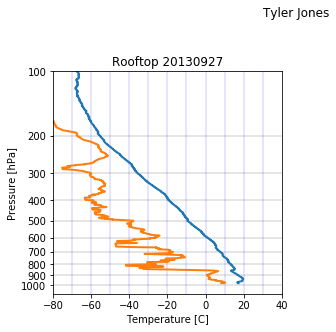

In [11]:

# create a canvas for the plot
myfig = plt.figure(1 , figsize=(9,9))
plt.suptitle("Tyler Jones")

# UPPER LEFT PANEL HAS SOUNDING -------------------------
plt.subplot(221)

# Create T-logp chart with isobars, isotherms, adiabats
make_Tlogp_frame()   

# Plot sounding
mysounding.plot_profile()

# LOWER LEFT PANEL HAS PRESSURE VS. Z ---------------

# Display or save plot
plt.show()
myfig.savefig("Lab02.pdf")